# Welcome !

PyMouseGesture is a project that aims to show how to build a simple Keras RNN model by using the example of interpreting mouse movement as gestures.

## Organization
1. [Collecting data](#Collecting_data)
1. [Cleaning and Structuring data](#Process_data)
1. [Data Visualization](#data_vis)
1. [Training and testing on RNN](#rnn_build)
1. [Training the 1d ConvNet model](#train_cnn)
1. [Live inference !](#Live_Inference)

<a id = "Collecting_data"></a>

## Collecting data


The data was collected using the python library [pynput](https://pypi.org/project/pynput/). The script mouse_data_collector.py is a helper script that is used to collect and label the mouse data simultaneously. However if you exit the script the collected data is written to the data.csv file in the directory overwriting any previous file of the same name.

The logic behind the script is simple:
- create a mouse event listener.
- define methods to be called when mouse is clicked and mouse is moved
- if mouse is moved collect data for the current gesture
- if mouse is clicked stop collecting data for the current gesture.
- ask the user to label the gesture
- save the collected data as a list of x and y co-ordinates

In [1]:
#first let us import the necessary packages and finish setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#set numpy random seed for reproducible results
np.random.seed(0)

%matplotlib inline

<a id = 'Process_data'></a>

## Cleaning and Structuring Data

Let us first read our collected data before doing anything else. We are using [pandas](https://pandas.pydata.org/) to read and manipulate the data.

In [41]:
#read data.csv using pd.read_csv
data = pd.read_csv('data.csv')
print(data.columns)
data.head()

Index(['sequence', 'x_coordinates', 'y_coordinates'], dtype='object')


,sequence,x_coordinates,y_coordinates
0,0,"[305, 305, 303, 299, 295, 289, 281, 272, 264, ...","[141, 141, 141, 141, 141, 139, 138, 137, 136, ..."
1,0,"[238, 234, 226, 214, 200, 175, 149, 124, 103, ...","[166, 165, 165, 165, 167, 174, 183, 194, 206, ..."
2,0,"[162, 157, 146, 134, 102, 69, 17, -37, -66, -5...","[257, 256, 253, 252, 250, 250, 255, 267, 293, ..."
3,0,"[239, 237, 234, 230, 223, 212, 199, 181, 162, ...","[205, 204, 204, 204, 204, 205, 209, 214, 219, ..."
4,0,"[248, 247, 245, 240, 226, 214, 188, 160, 120, ...","[221, 220, 219, 218, 217, 215, 214, 214, 214, ..."


As we saved our data into a csv file, while reading the file input, the list variables are read as strings. A helper function in the cell below *string_to_list* converts them back to integer lists.

In [42]:
type(data.at[0,'x_coordinates'])

str

In [43]:
def string_to_list(string_list):
    """
    Converts list read from csv as string back into integer list. Returns error if string literal has non numeric characters
    
    Args:
    ----
    string_list - A list of integers read as a string literal
    
    Returns:
    -------
    int_list - A list of integers corresponding to the input string list
    
    ##Example
    z = string_to_list(data.at[0,'x_coordinates']) where data is a pandas DataFrame
        
    """
    return list(map(int,string_list.strip('[]').split(',')))
    



We just defined a value of the maximum length of the sequence to be 75. This is obtained by analyzing the lengths of the sequences output from *string_to_list*. 

Also *m* represents the number of training examples. Here it is 101.

Feel free to replace the value of the index in the last line of the cell from 50 to anyother value. You will see values between 60 - 80.

In [44]:
#let maxLen be 120
maxLen = 75
m = data.shape[0]
print(m)
len(string_to_list(data.at[50,'x_coordinates']))

252


73

Now let us create our input and output variables. X will refer to our input variable of shape (2,m,maxLen) and Z will refer to our output variable of shape (m,)

X is initialized as a numpy array of zeros with m rows, 2 columns and depth equal to maxLen
Z is directly assigned values by converting a dataframe column to numpy array

In [45]:
X = np.zeros((m,2,maxLen))
Z = data['sequence'].values
print("The shape of X is ",X.shape)
print("The shape of Z is ",Z.shape)

The shape of X is  (252, 2, 75)
The shape of Z is  (252,)


Before we create store the values in the numpy array, let us scale the data appropriately so that the values lie in the range (0 - 1). I had intended to do this after storing my values in the numpy array. However the appended zeros in the array will be changed to non-zero values which is not a good idea. So I am scaling the data using the minimum and maximum values in the sequence. Another way would be to use domain knowledge such as the minimum and maximum values that pynput can give. However this is not availabe to us.

The system resolution of the test PC is 1366 x 768. However while running a simple program to output the mouse position, coordinates were often negative to the tune of -400 even. But we'll still use 1366 x 768 for the data.csv generated for this PC.

While inference, the scaling should be done using the screen resolution of the pc carrying out the inference. 

Therefore,
1. X_MAX = 1366
1. X_MIN = 0
1. Y_MAX = 768
1. Y_MIN = 0

In [46]:
def max_min_normalize(MAX,MIN,value):
    '''
    args:
    ----
    MAX - maximum value of the data distribution.
    MIN - minimum value of the data distribution.
    value - the value to be normalized.
    
    return:
    ------
    norm_value - the normalized value.
    
    norm_value = ( value - MIN ) / ( MAX - MIN )
        
    '''
    return (value - MIN) / (MAX - MIN)

Let's use Python's map function to normalize the sequence before storing it in an array.


In [47]:
X_MAX = 1366
X_MIN = 0
Y_MAX = 768
Y_MIN = 0

for i in range(m):
    x = map(lambda x:max_min_normalize(X_MAX,X_MIN,x),string_to_list(data.at[i,'x_coordinates']))
    y = map(lambda y:max_min_normalize(Y_MAX,Y_MIN,y),string_to_list(data.at[i,'y_coordinates']))
    x = list(x)
    y = list(y)
    if len(x) > maxLen:
        X[i,0,:len(x)] =x[:maxLen]
        X[i,1,:len(y)] =y[:maxLen]
    else:
        X[i,0,:len(x)] =x
        X[i,1,:len(y)] =y
        

Let's one hot encode the class labels. Let us now import the keras modules to build our network as well as one hot encode the data.

In [9]:
from keras.models import Model
from keras.layers import Dense,Input,Dropout,LSTM,Activation
from keras.initializers import glorot_uniform
from keras.utils import to_categorical

Using TensorFlow backend.


In [48]:
print(Z.shape)
Z = to_categorical(Z,5)
print(Z.shape)

(252,)
(252, 5)


## Training the RNN model <a id = 'rnn_build'></a>

In [49]:
def MouseClassify(input_shape):
    X_Input = Input(shape = input_shape,dtype=np.float32)
    X = LSTM(256,return_sequences=True)(X_Input)
    X = Dropout(0.5)(X)
    X = LSTM(128,return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(32)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    model = Model(X_Input,X)
    
    return model


In [50]:
model_0 = MouseClassify((75,2))
model_0.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [51]:
model_0.fit(x=np.swapaxes(X,1,2),y=Z,batch_size=25,epochs=15)
model_0.summary()

Epoch 1/15
252/252 [==============================] - 13s 51ms/step - loss: 1.6128 - acc: 0.1627
Epoch 2/15
252/252 [==============================] - 8s 33ms/step - loss: 1.6131 - acc: 0.1825
Epoch 3/15
252/252 [==============================] - 10s 40ms/step - loss: 1.6132 - acc: 0.1825
Epoch 4/15
252/252 [==============================] - 14s 54ms/step - loss: 1.6120 - acc: 0.1548
Epoch 5/15
252/252 [==============================] - 11s 44ms/step - loss: 1.6125 - acc: 0.1786
Epoch 6/15
252/252 [==============================] - 8s 32ms/step - loss: 1.6125 - acc: 0.2024
Epoch 7/15
252/252 [==============================] - 11s 46ms/step - loss: 1.6108 - acc: 0.1627
Epoch 8/15
252/252 [==============================] - 12s 48ms/step - loss: 1.6112 - acc: 0.2063
Epoch 9/15
252/252 [==============================] - 11s 45ms/step - loss: 1.6121 - acc: 0.1786
Epoch 10/15
252/252 [==============================] - 13s 51ms/step - loss: 1.6099 - acc: 0.1905
Epoch 11/15
252/252 [==========

In [152]:
result_array = model_0.predict(np.swapaxes(X[40:41],1,2),verbose=1)
print("Predicted label is :",np.argmax(result_array))
print("Actual label is :",np.argmax(Z[40]))

1/1 [==============================] - 0s 56ms/step
Predicted label is : 4
Actual label is : 2


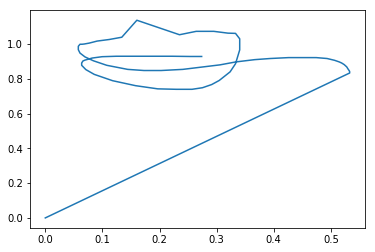

In [153]:
plt.plot(X[40,0,:],X[40,1,:])

From the model accuracy, we realize the model has failed to learn anything. The model is as good as randomly guessing the class labels. So its not very good. Let us try a one dimensional CNN before building on this model. The 1D CNN should have been the first choice as it can be trained faster and with lower params then a RNN. I assumed LSTM would do well with Temporal data without applying the simpler model first. My Bad.<br>

However one could improve this by training with a validation split for the data as I did for the ConvNet below. Also apply earlystopping and modelcheckpoint callbacks.

## Training the 1D ConvNet <a id = 'train_cnn'></a> 

In [70]:
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [67]:
def CNNMouseClassify(input_shape):
    X_input = Input(input_shape,dtype=np.float32)
    #Sequence classifier example on Keras website
    X = Conv1D(64,3,activation='relu')(X_input)
    X = Conv1D(64,3,activation='relu')(X)
    X = MaxPooling1D(3)(X)
    X = Conv1D(128,3,activation='relu')(X)
    X = Conv1D(128,3,activation='relu')(X)
    X = GlobalAveragePooling1D()(X)
    X = Dropout(0.5)(X)
    X = Dense(32)(X)
    X = Dense(5,activation='softmax')(X)
    return Model(X_input,X)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,Z,test_size = 0.25)
X_train.shape

(189, 2, 75)

In [103]:
model = CNNMouseClassify((75,2))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [107]:
#configure callbacks
es = EarlyStopping(monitor='val_loss',verbose=1,patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose = 1,mode='min', save_best_only=True)

Why not use validation accuracy? The main reason is that accuracy is a coarse measure of model performance during training and that loss provides more nuance when using early stopping with classification problems.

In [108]:
history = model.fit(x=np.swapaxes(X_train,1,2),y=y_train,batch_size=25,epochs=100,validation_data=(np.swapaxes(X_test,1,2),y_test),callbacks=[es,mc])

Train on 189 samples, validate on 63 samples
Epoch 1/100
189/189 [==============================] - 16s 84ms/step - loss: 1.6105 - acc: 0.1799 - val_loss: 1.5707 - val_acc: 0.2222

Epoch 00001: val_loss improved from inf to 1.57066, saving model to best_model.h5
Epoch 2/100
189/189 [==============================] - 12s 65ms/step - loss: 1.5688 - acc: 0.2804 - val_loss: 1.5298 - val_acc: 0.5714

Epoch 00002: val_loss improved from 1.57066 to 1.52980, saving model to best_model.h5
Epoch 3/100
189/189 [==============================] - 10s 55ms/step - loss: 1.5215 - acc: 0.4074 - val_loss: 1.4252 - val_acc: 0.5079

Epoch 00003: val_loss improved from 1.52980 to 1.42523, saving model to best_model.h5
Epoch 4/100
189/189 [==============================] - 12s 61ms/step - loss: 1.4253 - acc: 0.4974 - val_loss: 1.3564 - val_acc: 0.7460

Epoch 00004: val_loss improved from 1.42523 to 1.35640, saving model to best_model.h5
Epoch 5/100
189/189 [==============================] - 12s 66ms/step - 

189/189 [==============================] - 9s 50ms/step - loss: 0.2815 - acc: 0.8942 - val_loss: 0.2106 - val_acc: 0.9365

Epoch 00040: val_loss improved from 0.21993 to 0.21061, saving model to best_model.h5
Epoch 41/100
189/189 [==============================] - 10s 51ms/step - loss: 0.2454 - acc: 0.9153 - val_loss: 0.2151 - val_acc: 0.9365

Epoch 00041: val_loss did not improve from 0.21061
Epoch 42/100
189/189 [==============================] - 9s 50ms/step - loss: 0.2726 - acc: 0.9101 - val_loss: 0.1686 - val_acc: 0.9683

Epoch 00042: val_loss improved from 0.21061 to 0.16859, saving model to best_model.h5
Epoch 43/100
189/189 [==============================] - 10s 51ms/step - loss: 0.2922 - acc: 0.9048 - val_loss: 0.3083 - val_acc: 0.9206

Epoch 00043: val_loss did not improve from 0.16859
Epoch 44/100
189/189 [==============================] - 10s 50ms/step - loss: 0.2814 - acc: 0.9101 - val_loss: 0.2523 - val_acc: 0.9365

Epoch 00044: val_loss did not improve from 0.16859
Epoch

In [109]:
np.swapaxes(X,1,2).shape

(252, 75, 2)

In [110]:
print(model.predict(np.swapaxes(X[0:1],1,2),verbose=1))
Z[0:1]

1/1 [==============================] - 1s 943ms/step
[[9.9739033e-01 2.3483699e-06 1.4757680e-03 1.6244283e-06 1.1299369e-03]]


array([[1., 0., 0., 0., 0.]], dtype=float32)

## Live Inference <a id = 'Live_Inference' ></a> 

In [124]:
from pynput import mouse
from keras.models import load_model

In [78]:
def on_move(x,y):
    mouse_position_X.append(x)
    mouse_position_Y.append(y)
    
def on_click(x,y,button,pressed):
    return False

In [79]:

def GetMouseGesture():
    with mouse.Listener(on_move = on_move, on_click = on_click) as listener:
        listener.join()
    temp = np.zeros((1,maxLen,2))
    x = list(map(lambda x:max_min_normalize(X_MAX,X_MIN,x),mouse_position_X[:maxLen]))
    y = list(map(lambda y:max_min_normalize(Y_MAX,Y_MIN,y),mouse_position_Y[:maxLen]))
    if len(mouse_position_X) > maxLen:
        temp[0,:,0] = x
        temp[0,:,1] = y
    else:
        temp[0,:len(x),0] =x
        temp[0,:len(y),1] =y                       
    return temp

In [126]:
model_best = load_model('best_model.h5')

### Run the cell below for live inference.

Run the cell. Then move the mouse in a pattern like 0, 1, 2, 3, or 4.<br>
Perform a left click.<br>
The left click calls the mouse listener to exit and passes the data to the network for prediction

Wall time: 10.9 ms
4
[[1.6912643e-04 3.8453629e-05 8.1222068e-05 2.8799917e-03 9.9683124e-01]]


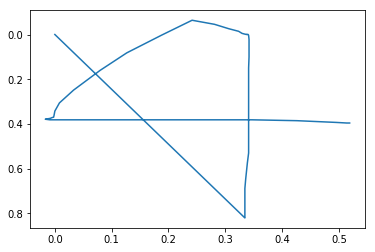

In [142]:

mouse_position_X = []
mouse_position_Y = []
X_predict = GetMouseGesture()

%time result_array = model_best.predict(X_predict)
print(np.argmax(result_array))
print(result_array)
plt.plot(X_predict[0,:,0],X_predict[0,:,1])
plt.gca().invert_yaxis()
plt.show()

In [120]:
a = [1,2,3]
print(a[:maxLen])
result_array

[1, 2, 3]


array([[1.8178780e-06, 4.1566016e-03, 9.9648896e-04, 8.4886992e-01,
        1.4597520e-01]], dtype=float32)

In [121]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 75, 2)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 73, 64)            448       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 71, 64)            12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 21, 128)           24704     
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 19, 128)           49280     
_________________________________________________________________
global_average_pooling1d_7 ( (None, 128)               0         
__________

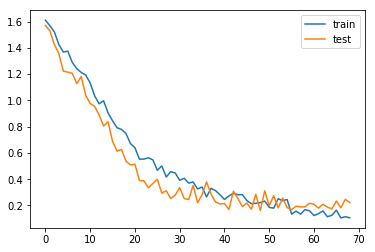

In [122]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()